In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
print(torch.cuda.device_count())            # Numero di GPU disponibili
print(torch.cuda.get_device_name(0))        # Nome della prima GPU disponibile
print(torch.cuda.current_device())        # Device in uso al momento
print(torch.cuda.set_device(0))             # Imposta la prima GPU come default
print(torch.cuda.get_device_capability(0))  # Verifica le capacità della prima GPU

1
Tesla T4
0
None
(7, 5)


In [ ]:
path = './drive/MyDrive/Materiale_Pellegrino_personal/NSLKDD/NSLKDD_Full.csv'
dataset = pd.read_csv(path)

In [ ]:
dataset

,duration,protocol_type,service,flag,symbolic,src_bytes,dst_bytes,DoS,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,binlabel,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,normal,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,normal,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,anomaly,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,normal,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148511,0,tcp,smtp,SF,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,21,normal,normal
148512,0,tcp,http,SF,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.0,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,21,normal,normal
148513,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.0,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,15,anomaly,DoS
148514,0,udp,domain_u,SF,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.0,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,21,normal,normal


In [ ]:
# Elimino la colonna 'num_access_files' poiché inutile
dataset = dataset.drop('num_access_files', axis=1)

# Elimino la colonna 'binlabel' dal dataset
dataset = dataset.drop('binlabel', axis=1)

In [ ]:
dep_var = 'label'
cat_names = ["protocol_type", "service", "flag"]
cont_names = [col for col in dataset.columns if col not in cat_names and col != dep_var]

In [ ]:
len(cont_names)

38

In [ ]:
# LabelEncoding della variabile target 
target_index = dataset.columns.get_loc(dep_var)
dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[dep_var])

#LabelEncoding delle variabili categoriali
for col in cat_names:
  target_index = dataset.columns.get_loc(col)
  dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[col])

In [ ]:
dataset.head()

,duration,protocol_type,service,flag,symbolic,src_bytes,dst_bytes,DoS,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,20,9,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,2
1,0,2,44,9,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,2
2,0,1,49,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,0
3,0,1,24,9,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,2
4,0,1,24,9,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,2


In [ ]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)

In [ ]:
y_train = train[dep_var]
train = train.drop(dep_var, axis=1)
y_test = test[dep_var]
test = test.drop(dep_var, axis=1)

# validation di 2500 righe da train
train, validation, y_train, y_val = train_test_split(train, y_train, test_size=0.033666, random_state=0)

In [ ]:
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

In [ ]:
y_val

array([3, 2, 2, ..., 0, 0, 0])

In [ ]:
test

,duration,protocol_type,service,flag,symbolic,src_bytes,dst_bytes,DoS,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
51891,0,1,49,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,14,1.00,1.0,0.0,0.0,0.14,0.06,0.00,255,14,0.05,0.05,0.00,0.00,1.0,1.0,0.0,0.0,21
102171,0,1,49,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,3,1.00,1.0,0.0,0.0,0.04,0.08,0.00,180,3,0.02,0.07,0.01,0.00,1.0,1.0,0.0,0.0,18
44390,0,1,49,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,258,20,1.00,1.0,0.0,0.0,0.08,0.05,0.00,255,5,0.02,0.08,0.00,0.00,1.0,1.0,0.0,0.0,21
127542,0,1,24,9,328,2375,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,11,19,0.00,0.0,0.0,0.0,1.00,0.00,0.21,24,255,1.00,0.00,0.04,0.02,0.0,0.0,0.0,0.0,21
11713,23120,2,44,9,146,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,0.17,0.0,0.0,0.0,0.33,0.50,0.00,255,2,0.01,0.56,0.88,0.00,0.0,0.0,0.0,0.0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65312,0,1,67,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,65,19,1.00,1.0,0.0,0.0,0.29,0.08,0.00,255,19,0.07,0.08,0.00,0.00,1.0,1.0,0.0,0.0,18
48932,0,1,24,9,218,306,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4,4,0.00,0.0,0.0,0.0,1.00,0.00,0.00,36,255,1.00,0.00,0.03,0.04,0.0,0.0,0.0,0.0,21
64242,24,1,19,9,239,774,0,0,0,4,0,1,0,0,0,0,0,0,0,0,1,1,1,0.00,0.0,0.0,0.0,1.00,0.00,0.00,3,2,0.67,0.67,0.33,0.00,0.0,0.0,0.0,0.0,21
94316,0,1,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,274,17,0.00,0.0,1.0,1.0,0.06,0.06,0.00,255,17,0.07,0.07,0.00,0.00,0.0,0.0,1.0,1.0,20


In [ ]:
train

,duration,protocol_type,service,flag,symbolic,src_bytes,dst_bytes,DoS,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
119981,0,1,54,9,1041,330,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,82,184,0.72,0.07,0.01,0.01,0.00,0.00,0.0,0.0,21
71403,8855,1,44,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,1.0,1.0,1.00,0.00,0.00,255,2,0.01,0.74,1.00,0.00,0.00,0.00,1.0,1.0,15
61697,0,1,49,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,122,18,1.0,1.0,0.0,0.0,0.15,0.07,0.00,255,19,0.07,0.07,0.00,0.00,1.00,1.00,0.0,0.0,21
15939,0,1,24,9,214,1533,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,12,13,0.0,0.0,0.0,0.0,1.00,0.00,0.15,132,255,1.00,0.00,0.01,0.01,0.00,0.00,0.0,0.0,21
140372,0,2,44,9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,159,10,0.0,0.0,0.0,0.0,0.06,0.47,0.00,255,10,0.04,0.65,1.00,0.00,0.00,0.00,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70332,0,1,24,9,197,5790,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,21
749,0,1,24,9,327,6721,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4,5,0.0,0.0,0.0,0.0,1.00,0.00,0.40,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,21
73724,0,1,41,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,8,1.0,1.0,0.0,0.0,0.08,0.06,0.00,255,15,0.06,0.05,0.00,0.00,1.00,1.00,0.0,0.0,18
14423,0,1,20,9,1874,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,11,0.0,0.0,0.0,0.0,0.92,0.17,0.00,49,102,0.67,0.14,0.71,0.02,0.00,0.00,0.0,0.0,20


In [ ]:
#### Fase di Categorical Embeddings ###############

for col in cat_names:
  train[col] = train[col].astype('category')

embedded_cols = {n: len(col.cat.categories) for n,col in train[cat_names].items()}
print(embedded_cols)

embedded_col_names = cat_names

# Determiniamo una funzione per la dimensione dell'incorporamento, presa da una libreria 
embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) for _,n_categories in embedded_cols.items()]
embedding_sizes

{'protocol_type': 3, 'service': 68, 'flag': 11}


[(3, 2), (68, 34), (11, 6)]

In [ ]:
""" Pytorch Dataset e DataLoader
Estendiamo la Dataset classe (astratta) fornita da Pytorch per un accesso più facile al nostro set di dati durante l'addestramento 
e per utilizzare efficacemente  il DataLoader modulo per gestire i batch. Ciò comporta la sovrascrittura dei metodi __len__e __getitem__
secondo il nostro particolare set di dati.
Poiché abbiamo solo bisogno di incorporare colonne categoriali, dividiamo il nostro input in due parti: numerico e categoriale. """ 

class NSLKDD_Dataset(Dataset):
    def __init__(self, X, Y, embedded_col_names):
        X = X.copy()
        self.X1 = X.loc[:,embedded_col_names].copy().values.astype(np.int64) #categorical columns
        self.X2 = X.drop(columns=embedded_col_names).copy().values.astype(np.float32) #numerical columns
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]
        
#creating train and valid datasets
train_ds = NSLKDD_Dataset(train, y_train, embedded_col_names)
valid_ds = NSLKDD_Dataset(validation, y_val, embedded_col_names)

In [ ]:
train_ds.X2

array([[0.0000e+00, 1.0410e+03, 3.3000e+02, ..., 0.0000e+00, 0.0000e+00,
        2.1000e+01],
       [8.8550e+03, 1.0000e+00, 0.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        1.5000e+01],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        2.1000e+01],
       ...,
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.8000e+01],
       [0.0000e+00, 1.8740e+03, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        2.0000e+01],
       [1.4479e+04, 8.4120e+03, 1.2031e+04, ..., 0.0000e+00, 0.0000e+00,
        1.6000e+01]], dtype=float32)

In [ ]:
""" Making device (GPU/CPU) compatible

(borrowed from https://jovian.ml/aakashns/04-feedforward-nn)

In order to make use of a GPU if available, we'll have to move our data and model to it. """ 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [ ]:
""" I nostri dati sono suddivisi in parti continue e categoriali. Per prima cosa convertiamo le parti categoriali in vettori 
incorporanti in base alle dimensioni determinate in precedenza e le concateniamo con le parti continue per alimentare il resto della rete """ 

class NSLKDDModel(nn.Module):
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings)  #length of all embeddings combined
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 200)
        self.lin2 = nn.Linear(200, 70)
        self.lin3 = nn.Linear(70, 5)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(70)
        self.emb_drop = nn.Dropout(0.6)
        self.drops = nn.Dropout(0.3)
        

    def forward(self, x_cat, x_cont):
        #x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x = [e(x_cat[:,0]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

In [ ]:
""" Fase di preparazione per l'addestramento """

# Optimizer
def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

# Training function
def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x1, x2, y in train_dl:
        batch = y.shape[0]
        output = model(x1, x2)
        loss = F.cross_entropy(output, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

# Evaluation function
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x1, x2, y in valid_dl:
        current_batch_size = y.shape[0]
        out = model(x1, x2)
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    #print("valid loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
    print('valid loss ', sum_loss/total, ' and accuracy ', correct/total)
    return sum_loss/total, correct/total

# Funzione per l'addestramento 
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print('ep ', i, "training loss: ", loss)
        val_loss(model, valid_dl)

In [ ]:
model = NSLKDDModel(embedding_sizes, len(cont_names))
to_device(model, device)

NSLKDDModel(
  (embeddings): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(68, 34)
    (2): Embedding(11, 6)
  )
  (lin1): Linear(in_features=80, out_features=200, bias=True)
  (lin2): Linear(in_features=200, out_features=70, bias=True)
  (lin3): Linear(in_features=70, out_features=5, bias=True)
  (bn1): BatchNorm1d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (emb_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)

In [ ]:
""" Ora addestriamo il modello sul set di addestramento. Ho usato l'ottimizzatore Adam per ottimizzare la perdita di entropia incrociata. 
L'addestramento è piuttosto semplice: iterare attraverso ogni batch, eseguire un passaggio in avanti, calcolare i gradienti, 
eseguire una discesa del gradiente e ripetere questo processo per tutte le epoche necessarie. """ 

batch_size = 512
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [ ]:
train_loop(model, epochs=500, lr=0.001, wd=0.002)

ep  0 training loss:  0.3509288188815034
valid loss  0.1141541720867157  and accuracy  0.9656
ep  1 training loss:  0.10777016501668046
valid loss  0.06726433721780777  and accuracy  0.9784
ep  2 training loss:  0.07812237313655332
valid loss  0.05598678565621376  and accuracy  0.9804
ep  3 training loss:  0.06272547082011608
valid loss  0.06337571187615394  and accuracy  0.9864
ep  4 training loss:  0.054448839710100914
valid loss  0.05552811758518219  and accuracy  0.9908
ep  5 training loss:  0.05017270808876202
valid loss  0.03523318614959717  and accuracy  0.9928
ep  6 training loss:  0.045880192583584396
valid loss  0.03574569497704506  and accuracy  0.9892
ep  7 training loss:  0.043398673253391855
valid loss  0.03127266548871994  and accuracy  0.99
ep  8 training loss:  0.042903887095145414
valid loss  0.03444221029877663  and accuracy  0.9884
ep  9 training loss:  0.040490738830835635
valid loss  0.03441407506465912  and accuracy  0.9924
ep  10 training loss:  0.03882005995024

In [ ]:
""" Effettuiamo le predizioni sul dataset di test """

test_ds = NSLKDD_Dataset(test, np.zeros(len(test)), embedded_col_names)
test_dl = DataLoader(test_ds, batch_size=batch_size)
test_dl = DeviceDataLoader(test_dl, device)

# Utilizziamo la funzione softmax poiché siamo interessati alla probabilità per ogni classe
preds = []
with torch.no_grad():
    for x1,x2,y in test_dl:
        out = model(x1, x2)
        prob = F.softmax(out, dim=1)
        preds.append(prob)

In [ ]:
y_pred = []
for i in range(0, len(preds)):
  pred = preds[i].cpu()
  temp = np.argmax(pred, 1)
  temp = np.array(temp)
  y_pred = np.append(y_pred, temp)

y_pred = y_pred.astype(int)

In [ ]:
y_pred

array([0, 0, 0, ..., 2, 0, 0])

In [ ]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({2: 38484, 0: 26586, 1: 7026, 3: 2093, 4: 69})
Pred: Counter({2: 38383, 0: 26585, 1: 7119, 3: 2101, 4: 70})


In [ ]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

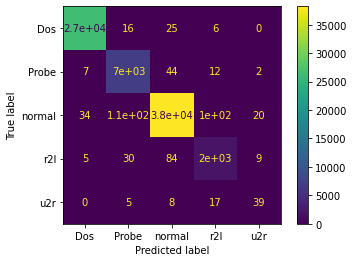

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

target_dict = {'Dos' : 0,
               'Probe' : 1,
               'normal' : 2,
               'r2l' : 3,
               'u2r' : 4}

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [ ]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

[[[47626    46]
  [   47 26539]]

 [[67074   158]
  [   65  6961]]

 [[35613   161]
  [  262 38222]]

 [[72029   136]
  [  128  1965]]

 [[74158    31]
  [   30    39]]]


In [ ]:
print(cm)

[[26539    16    25     6     0]
 [    7  6961    44    12     2]
 [   34   107 38222   101    20]
 [    5    30    84  1965     9]
 [    0     5     8    17    39]]


In [ ]:
FP = cm.sum (axis = 0) - np.diag (cm) 
FN = cm.sum (axis = 1) - np.diag (cm) 
TP = np.diag (cm) 
TN = cm.sum () - (FP + FN + TP)

print('True positive: ', TP)
print('True negative: ', TN)
print('False positive: ', FP)
print('False negative: ', FN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('True positive rate: ', TPR)
print('True negative rate: ', TNR)
print('False positive rate: ', FPR)
print('False negative rate: ', FNR)

True positive:  [26539  6961 38222  1965    39]
True negative:  [47626 67074 35613 72029 74158]
False positive:  [ 46 158 161 136  31]
False negative:  [ 47  65 262 128  30]
True positive rate:  [0.99823215 0.99074865 0.99319198 0.93884376 0.56521739]
True negative rate:  [0.99903507 0.99764993 0.99549952 0.99811543 0.99958215]
False positive rate:  [0.00096493 0.00235007 0.00450048 0.00188457 0.00041785]
False negative rate:  [0.00176785 0.00925135 0.00680802 0.06115624 0.43478261]


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26586
           1       0.98      0.99      0.98      7026
           2       1.00      0.99      0.99     38484
           3       0.94      0.94      0.94      2093
           4       0.56      0.57      0.56        69

    accuracy                           0.99     74258
   macro avg       0.89      0.90      0.90     74258
weighted avg       0.99      0.99      0.99     74258



In [ ]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.9928357887365671
Precision_weighted:  0.992870793427401
Recall_weighted:  0.9928357887365671
mcc:  0.9879440111655603
f2:  0.9928427894772722
